## Modules

In [51]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [52]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.1
Num GPUs: 1


## Funções Uteis

In [53]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [54]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [55]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [56]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [57]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [58]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [59]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


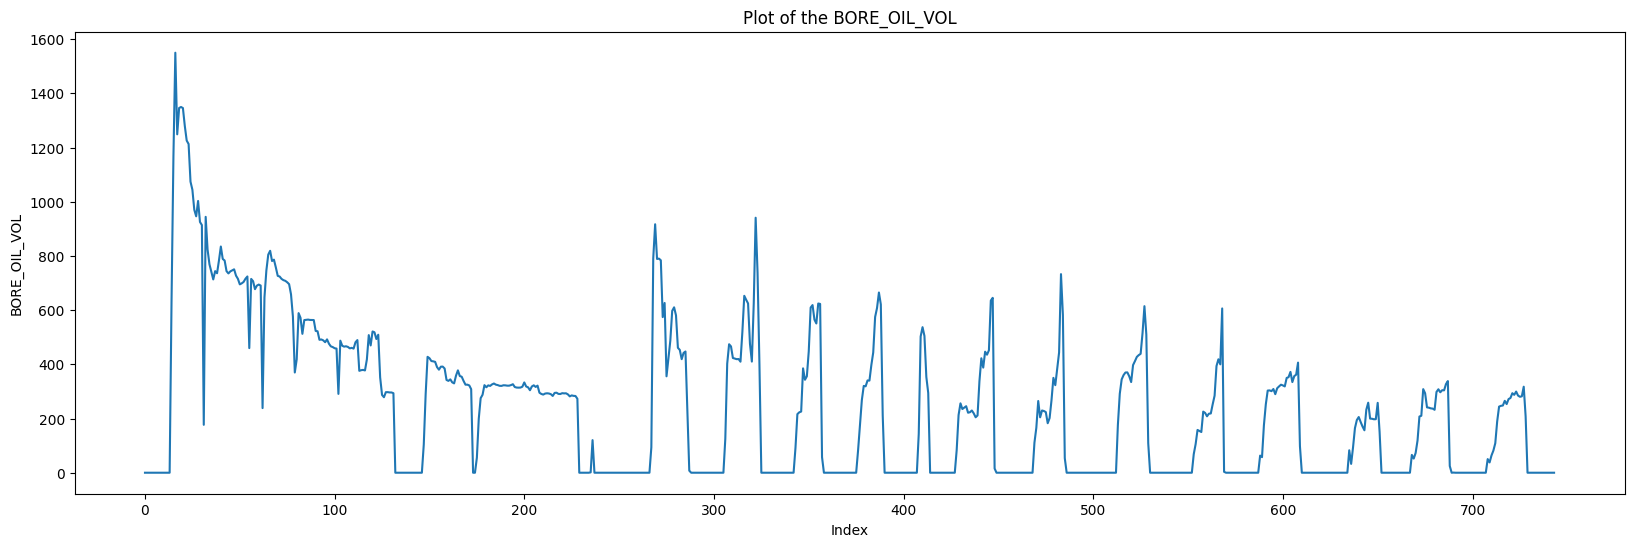

In [60]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [61]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [62]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


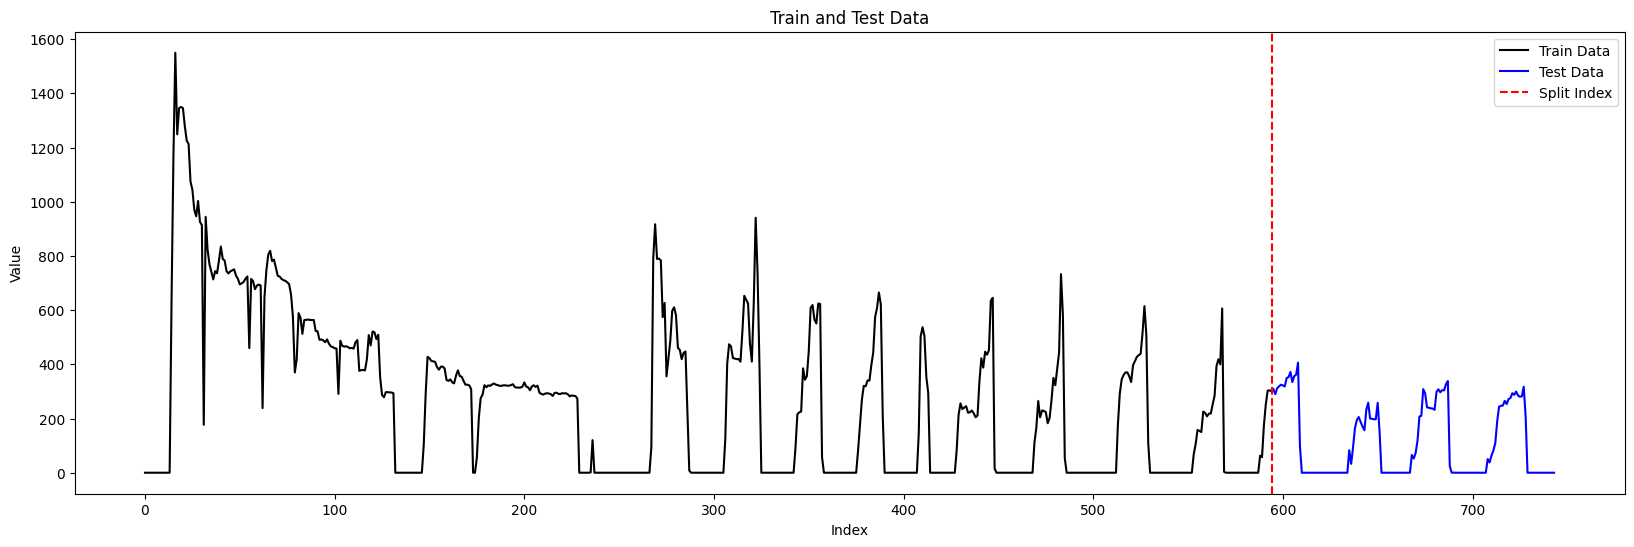

In [63]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [64]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [65]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [66]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [67]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [68]:
epochs = 1000 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [69]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [70]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

In [71]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# LSTM Model

In [72]:
# pip install optuna
!pip install optuna-integration


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [74]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [75]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 10)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = 1e-4#trial.suggest_float('learning_rate', 1e-4, 1e-2)
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
    model_LSTM.add(LSTM(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=300, batch_size=1, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [76]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2023-10-13 09:24:37,664] A new study created in memory with name: no-name-f30dad13-067a-4a46-8e9d-b1c5b567c946


In [77]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=100)



INFO:tensorflow:Assets written to: ram://b82e53b5-5b76-43c5-a189-19c09d55bedb/assets


INFO:tensorflow:Assets written to: ram://b82e53b5-5b76-43c5-a189-19c09d55bedb/assets
[I 2023-10-13 09:36:34,952] Trial 0 finished with value: 0.0016723154112696648 and parameters: {'n_lstm_layers': 3, 'lstm_units': 125}. Best is trial 0 with value: 0.0016723154112696648.


INFO:tensorflow:Assets written to: ram://1899da30-6fac-4c80-b17b-4b6cb77eee58/assets


INFO:tensorflow:Assets written to: ram://1899da30-6fac-4c80-b17b-4b6cb77eee58/assets
[I 2023-10-13 09:58:41,552] Trial 1 finished with value: 0.0021698689088225365 and parameters: {'n_lstm_layers': 7, 'lstm_units': 59}. Best is trial 0 with value: 0.0016723154112696648.


INFO:tensorflow:Assets written to: ram://6876bfb9-4d00-4c6a-88da-5c37a86efaf1/assets


INFO:tensorflow:Assets written to: ram://6876bfb9-4d00-4c6a-88da-5c37a86efaf1/assets
[I 2023-10-13 10:25:53,415] Trial 2 finished with value: 0.0018716455670073628 and parameters: {'n_lstm_layers': 9, 'lstm_units': 83}. Best is trial 0 with value: 0.0016723154112696648.


INFO:tensorflow:Assets written to: ram://de666bf9-536b-469d-85d0-87445a2bbec0/assets


INFO:tensorflow:Assets written to: ram://de666bf9-536b-469d-85d0-87445a2bbec0/assets
[I 2023-10-13 10:40:28,123] Trial 3 finished with value: 0.0017508476739749312 and parameters: {'n_lstm_layers': 4, 'lstm_units': 125}. Best is trial 0 with value: 0.0016723154112696648.


INFO:tensorflow:Assets written to: ram://6e91defe-5114-43d6-a70d-50147a291722/assets


INFO:tensorflow:Assets written to: ram://6e91defe-5114-43d6-a70d-50147a291722/assets
[I 2023-10-13 11:00:10,374] Trial 4 finished with value: 0.0028301384299993515 and parameters: {'n_lstm_layers': 6, 'lstm_units': 192}. Best is trial 0 with value: 0.0016723154112696648.


INFO:tensorflow:Assets written to: ram://97f1cad0-ae2f-4d86-af7c-33bbc9cb59c0/assets


INFO:tensorflow:Assets written to: ram://97f1cad0-ae2f-4d86-af7c-33bbc9cb59c0/assets
[I 2023-10-13 11:13:06,220] Trial 5 finished with value: 0.001581091433763504 and parameters: {'n_lstm_layers': 3, 'lstm_units': 251}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 11:13:50,848] Trial 6 pruned. 


INFO:tensorflow:Assets written to: ram://42b70960-41a7-49c8-8d1a-bf927690f0b7/assets


INFO:tensorflow:Assets written to: ram://42b70960-41a7-49c8-8d1a-bf927690f0b7/assets
[I 2023-10-13 11:32:36,447] Trial 7 finished with value: 0.00209069368429482 and parameters: {'n_lstm_layers': 5, 'lstm_units': 207}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 11:32:47,520] Trial 8 pruned. 
[I 2023-10-13 11:32:59,252] Trial 9 pruned. 
[I 2023-10-13 11:33:29,375] Trial 10 pruned. 
[I 2023-10-13 11:33:56,586] Trial 11 pruned. 
[I 2023-10-13 11:34:39,261] Trial 12 pruned. 
[I 2023-10-13 11:34:46,789] Trial 13 pruned. 
[I 2023-10-13 11:35:18,785] Trial 14 pruned. 


INFO:tensorflow:Assets written to: ram://96b93ab0-6b79-4c46-8baa-6cf8f7f50d93/assets


INFO:tensorflow:Assets written to: ram://96b93ab0-6b79-4c46-8baa-6cf8f7f50d93/assets
[I 2023-10-13 11:50:30,181] Trial 15 finished with value: 0.0019021362531930208 and parameters: {'n_lstm_layers': 4, 'lstm_units': 208}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 11:51:05,748] Trial 16 pruned. 
[I 2023-10-13 11:51:20,655] Trial 17 pruned. 


INFO:tensorflow:Assets written to: ram://11d36535-9acd-4e2c-b3a4-eac64c486321/assets


INFO:tensorflow:Assets written to: ram://11d36535-9acd-4e2c-b3a4-eac64c486321/assets
[I 2023-10-13 12:06:56,028] Trial 18 finished with value: 0.0019224549178034067 and parameters: {'n_lstm_layers': 4, 'lstm_units': 228}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 12:07:04,673] Trial 19 pruned. 
[I 2023-10-13 12:07:37,837] Trial 20 pruned. 
[I 2023-10-13 12:07:45,355] Trial 21 pruned. 
[I 2023-10-13 12:08:16,676] Trial 22 pruned. 
[I 2023-10-13 12:08:46,863] Trial 23 pruned. 
[I 2023-10-13 12:08:55,478] Trial 24 pruned. 
[I 2023-10-13 12:09:22,941] Trial 25 pruned. 
[I 2023-10-13 12:09:48,041] Trial 26 pruned. 
[I 2023-10-13 12:10:14,808] Trial 27 pruned. 
[I 2023-10-13 12:10:25,194] Trial 28 pruned. 
[I 2023-10-13 12:10:36,448] Trial 29 pruned. 
[I 2023-10-13 12:10:43,252] Trial 30 pruned. 
[I 2023-10-13 12:10:57,102] Trial 31 pruned. 
[I 2023-10-13 12:11:10,192] Trial 32 pruned. 
[I 2023-10-13 12:11:21,936] Trial 33 pruned. 
[I 2023-10-13 12:11:30,081] Trial 34 p

INFO:tensorflow:Assets written to: ram://7a6cc69b-e1b9-4c14-b1f8-78f031a4574a/assets


INFO:tensorflow:Assets written to: ram://7a6cc69b-e1b9-4c14-b1f8-78f031a4574a/assets
[I 2023-10-13 12:24:21,701] Trial 37 finished with value: 0.001606125384569168 and parameters: {'n_lstm_layers': 3, 'lstm_units': 200}. Best is trial 5 with value: 0.001581091433763504.


INFO:tensorflow:Assets written to: ram://4612f25b-e021-419f-8158-a5985df66f3f/assets


INFO:tensorflow:Assets written to: ram://4612f25b-e021-419f-8158-a5985df66f3f/assets
[I 2023-10-13 12:37:23,085] Trial 38 finished with value: 0.0018878744449466467 and parameters: {'n_lstm_layers': 3, 'lstm_units': 247}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 12:37:54,417] Trial 39 pruned. 


INFO:tensorflow:Assets written to: ram://ac609647-bef5-4ad6-998c-295eab184e14/assets


INFO:tensorflow:Assets written to: ram://ac609647-bef5-4ad6-998c-295eab184e14/assets
[I 2023-10-13 12:50:59,349] Trial 40 finished with value: 0.0016864176141098142 and parameters: {'n_lstm_layers': 3, 'lstm_units': 197}. Best is trial 5 with value: 0.001581091433763504.


INFO:tensorflow:Assets written to: ram://0effbf66-3ca8-4556-b998-897b614e50d1/assets


INFO:tensorflow:Assets written to: ram://0effbf66-3ca8-4556-b998-897b614e50d1/assets
[I 2023-10-13 13:03:57,440] Trial 41 finished with value: 0.0016826031496748328 and parameters: {'n_lstm_layers': 3, 'lstm_units': 191}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 13:04:33,832] Trial 42 pruned. 
[I 2023-10-13 13:05:02,550] Trial 43 pruned. 
[I 2023-10-13 13:05:23,618] Trial 44 pruned. 
[I 2023-10-13 13:05:36,619] Trial 45 pruned. 
[I 2023-10-13 13:07:01,574] Trial 46 pruned. 


INFO:tensorflow:Assets written to: ram://53349f4f-f8f1-46e8-8006-02326701aaa0/assets


INFO:tensorflow:Assets written to: ram://53349f4f-f8f1-46e8-8006-02326701aaa0/assets
[I 2023-10-13 13:20:26,857] Trial 47 finished with value: 0.0021116493735462427 and parameters: {'n_lstm_layers': 3, 'lstm_units': 213}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 13:20:50,093] Trial 48 pruned. 
[I 2023-10-13 13:20:59,492] Trial 49 pruned. 
[I 2023-10-13 13:21:06,677] Trial 50 pruned. 
[I 2023-10-13 13:21:19,680] Trial 51 pruned. 
[I 2023-10-13 13:21:26,808] Trial 52 pruned. 
[I 2023-10-13 13:21:55,367] Trial 53 pruned. 
[I 2023-10-13 13:22:08,168] Trial 54 pruned. 
[I 2023-10-13 13:22:15,048] Trial 55 pruned. 
[I 2023-10-13 13:22:23,158] Trial 56 pruned. 
[I 2023-10-13 13:22:51,772] Trial 57 pruned. 
[I 2023-10-13 13:23:04,132] Trial 58 pruned. 
[I 2023-10-13 13:23:11,468] Trial 59 pruned. 
[I 2023-10-13 13:23:31,124] Trial 60 pruned. 


INFO:tensorflow:Assets written to: ram://9123254a-7e8a-4443-b4c0-1af09c6f125c/assets


INFO:tensorflow:Assets written to: ram://9123254a-7e8a-4443-b4c0-1af09c6f125c/assets
[I 2023-10-13 13:36:23,593] Trial 61 finished with value: 0.0016438643215224147 and parameters: {'n_lstm_layers': 3, 'lstm_units': 232}. Best is trial 5 with value: 0.001581091433763504.


INFO:tensorflow:Assets written to: ram://ea497c01-509c-4ad4-939d-a4bfd3485e2e/assets


INFO:tensorflow:Assets written to: ram://ea497c01-509c-4ad4-939d-a4bfd3485e2e/assets
[I 2023-10-13 13:48:59,738] Trial 62 finished with value: 0.0016809719381853938 and parameters: {'n_lstm_layers': 3, 'lstm_units': 232}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 13:49:28,713] Trial 63 pruned. 
[I 2023-10-13 13:50:46,646] Trial 64 pruned. 
[I 2023-10-13 13:51:59,654] Trial 65 pruned. 
[I 2023-10-13 13:52:28,330] Trial 66 pruned. 
[I 2023-10-13 13:53:21,432] Trial 67 pruned. 
[I 2023-10-13 13:53:28,637] Trial 68 pruned. 
[I 2023-10-13 13:53:57,442] Trial 69 pruned. 
[I 2023-10-13 13:54:25,873] Trial 70 pruned. 
[I 2023-10-13 13:54:32,684] Trial 71 pruned. 
[I 2023-10-13 13:54:38,238] Trial 72 pruned. 
[I 2023-10-13 13:54:44,075] Trial 73 pruned. 
[I 2023-10-13 13:54:51,458] Trial 74 pruned. 
[I 2023-10-13 13:55:19,968] Trial 75 pruned. 
[I 2023-10-13 13:55:34,033] Trial 76 pruned. 


INFO:tensorflow:Assets written to: ram://37688392-669d-4aaf-b2fd-7c002f328fdb/assets


INFO:tensorflow:Assets written to: ram://37688392-669d-4aaf-b2fd-7c002f328fdb/assets
[I 2023-10-13 14:08:43,351] Trial 77 finished with value: 0.0017306326190009713 and parameters: {'n_lstm_layers': 3, 'lstm_units': 222}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 14:09:06,071] Trial 78 pruned. 
[I 2023-10-13 14:10:18,273] Trial 79 pruned. 
[I 2023-10-13 14:10:46,483] Trial 80 pruned. 
[I 2023-10-13 14:10:53,909] Trial 81 pruned. 
[I 2023-10-13 14:12:05,534] Trial 82 pruned. 
[I 2023-10-13 14:12:12,506] Trial 83 pruned. 


INFO:tensorflow:Assets written to: ram://5fb26808-9686-48ef-b3ba-c76860ae328c/assets


INFO:tensorflow:Assets written to: ram://5fb26808-9686-48ef-b3ba-c76860ae328c/assets
[I 2023-10-13 14:24:57,509] Trial 84 finished with value: 0.0017696191789582372 and parameters: {'n_lstm_layers': 3, 'lstm_units': 220}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 14:25:03,261] Trial 85 pruned. 
[I 2023-10-13 14:25:33,069] Trial 86 pruned. 
[I 2023-10-13 14:25:41,565] Trial 87 pruned. 
[I 2023-10-13 14:26:13,720] Trial 88 pruned. 
[I 2023-10-13 14:26:19,729] Trial 89 pruned. 
[I 2023-10-13 14:26:28,556] Trial 90 pruned. 
[I 2023-10-13 14:27:38,028] Trial 91 pruned. 


INFO:tensorflow:Assets written to: ram://9f1a39d5-1622-4fb7-b313-1c940eb64382/assets


INFO:tensorflow:Assets written to: ram://9f1a39d5-1622-4fb7-b313-1c940eb64382/assets
[I 2023-10-13 14:40:27,861] Trial 92 finished with value: 0.0018576880684122443 and parameters: {'n_lstm_layers': 3, 'lstm_units': 216}. Best is trial 5 with value: 0.001581091433763504.


INFO:tensorflow:Assets written to: ram://611fd402-076d-40f0-9930-7b347846bd72/assets


INFO:tensorflow:Assets written to: ram://611fd402-076d-40f0-9930-7b347846bd72/assets
[I 2023-10-13 14:53:48,289] Trial 93 finished with value: 0.0017167283222079277 and parameters: {'n_lstm_layers': 3, 'lstm_units': 241}. Best is trial 5 with value: 0.001581091433763504.
[I 2023-10-13 14:53:55,921] Trial 94 pruned. 
[I 2023-10-13 14:54:51,052] Trial 95 pruned. 
[I 2023-10-13 14:55:19,266] Trial 96 pruned. 
[I 2023-10-13 14:55:28,055] Trial 97 pruned. 
[I 2023-10-13 14:55:35,184] Trial 98 pruned. 
[I 2023-10-13 14:55:46,049] Trial 99 pruned. 


In [78]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'n_lstm_layers': 3, 'lstm_units': 251}
Best Validation Loss: 0.001581091433763504


In [79]:
study.best_params['n_lstm_layers']

3

In [80]:
study.best_trial.number

5

In [81]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = 1e-4#study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)
best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
best_model_LSTM.add(LSTM(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=300, batch_size=1, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [82]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

4/4 [==============================] - 0s 0s/step


In [83]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.0017457858747753773
Test MSE: 0.001805771980871908


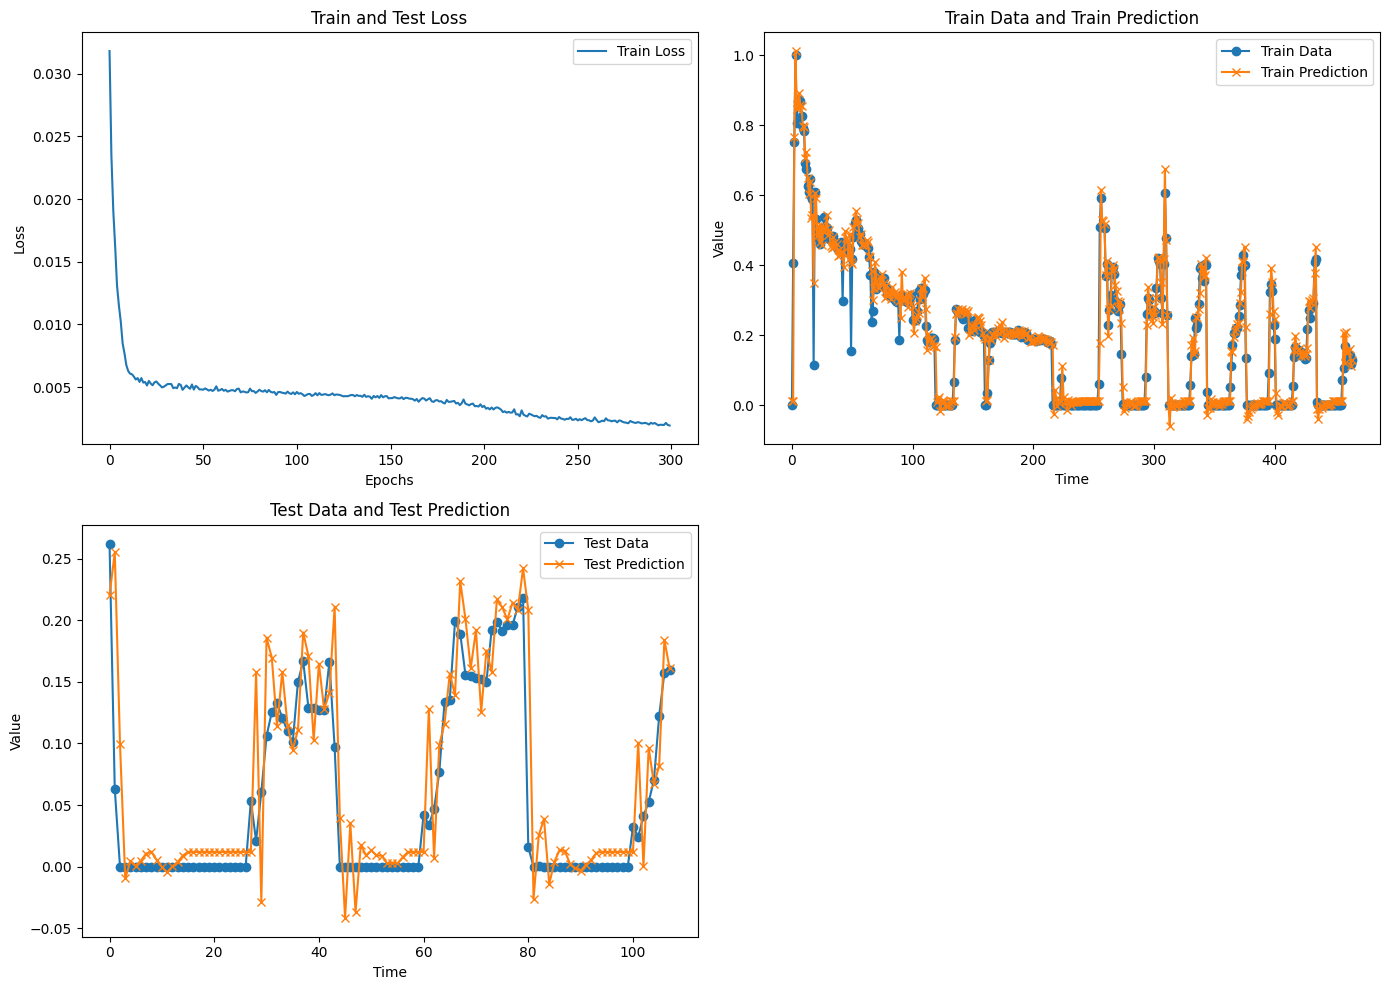

In [84]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

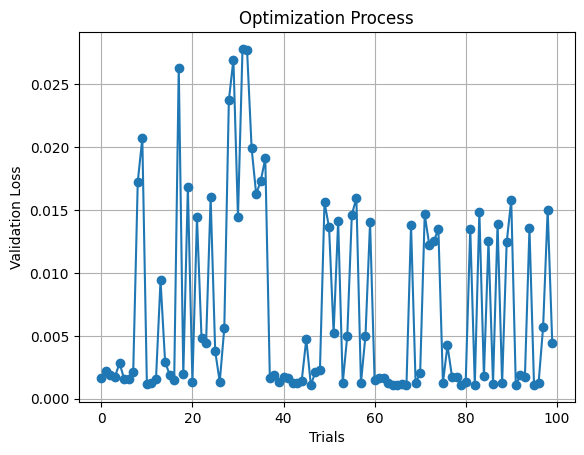

In [85]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

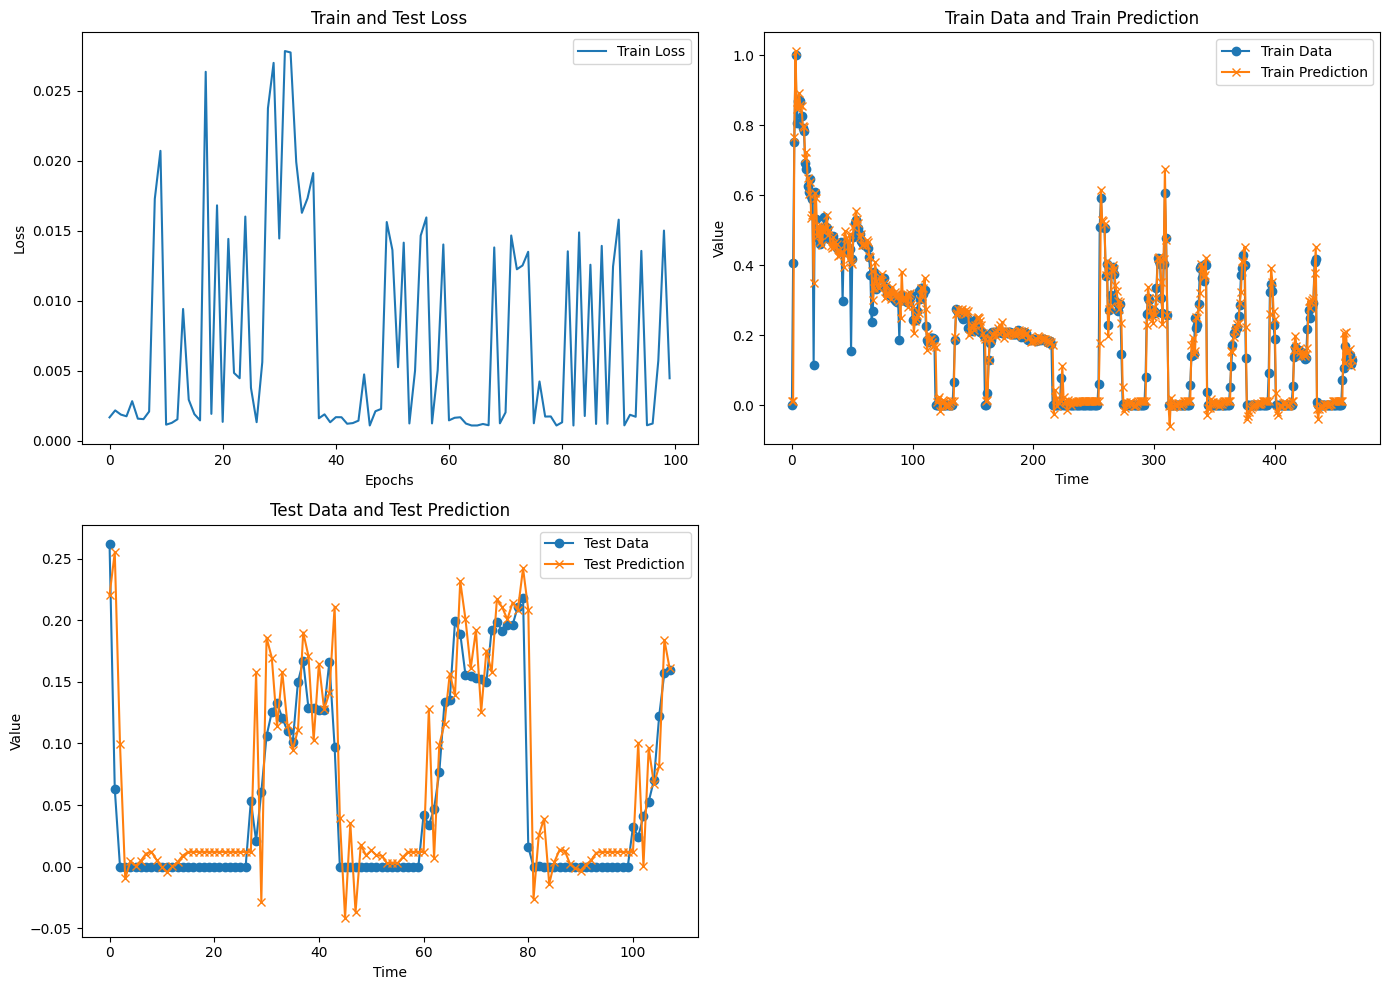

In [86]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

In [87]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [88]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [89]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [90]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [91]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [92]:
# from keras.utils.vis_utils import plot_model


In [93]:
# plot_model(model_LSTM)

In [94]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [95]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [96]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.0054905628077627664
Test MSE: 0.0018618443557413139


In [97]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [98]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.001746  0.001806
1  Baseline   0.005491  0.001862


In [99]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [100]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'n_lstm_layers': 3, 'lstm_units': 125}
Trial 2: {'n_lstm_layers': 7, 'lstm_units': 59}
Trial 3: {'n_lstm_layers': 9, 'lstm_units': 83}
Trial 4: {'n_lstm_layers': 4, 'lstm_units': 125}
Trial 5: {'n_lstm_layers': 6, 'lstm_units': 192}
Trial 6: {'n_lstm_layers': 3, 'lstm_units': 251}
Trial 7: {'n_lstm_layers': 3, 'lstm_units': 140}
Trial 8: {'n_lstm_layers': 5, 'lstm_units': 207}
Trial 9: {'n_lstm_layers': 6, 'lstm_units': 106}
Trial 10: {'n_lstm_layers': 7, 'lstm_units': 235}
Trial 11: {'n_lstm_layers': 1, 'lstm_units': 256}
Trial 12: {'n_lstm_layers': 1, 'lstm_units': 173}
Trial 13: {'n_lstm_layers': 3, 'lstm_units': 161}
Trial 14: {'n_lstm_layers': 3, 'lstm_units': 35}
Trial 15: {'n_lstm_layers': 2, 'lstm_units': 103}
Trial 16: {'n_lstm_layers': 4, 'lstm_units': 208}
Trial 17: {'n_lstm_layers': 2, 'lstm_units': 160}
Trial 18: {'n_lstm_layers': 10, 'lstm_units': 126}
Trial 19: {'n_lstm_layers': 4, 'lstm_units': 228}
Trial 20: {'n_lstm_